## Going Deeper(NLP)_RS5
## 3. 멋진 단어사전 만들기 [프로젝트]
### 프로젝트: SentencePiece 사용하기
#### 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


#### 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기
* 네이버 영화리뷰 감정 분석 태스크: 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용
* tokenizer를 SentencePiece로 바꾸어 KoNLPy에 있는 Mecab, kkma, Okt 등과 비교
###### 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습
###### 학습된 모델로 sp_tokenize() 메소드 구현
###### 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습
###### KoNLPy 형태소 분석기를 사용한 모델과 성능 비교
###### SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인
* Step 1. SentencePiece 설치하기
* pip install sentencepiece
* Step 2. SentencePiece 모델 학습
* Step 3. Tokenizer 함수 작성
######  훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의
###### SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어려움
###### 조건 1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달
###### 조건 2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환
###### 조건 3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장, 바로 학습에 사용할 수 있게 Padding

#### 데이터 가져오기
* wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
* mv ratings_*.txt ~/aiffel/sp_tokenizer/data

In [2]:
# 데이터 가져오기
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어오기
train_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_test.txt')

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train_data.head()

train 데이터 사이즈: 150000
test 데이터 사이즈: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### 전처리

In [3]:
# 중복된 내용과 결측치 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train 데이터 사이즈: 146182
test 데이터 사이즈: 49157


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/tmp/ipykernel_4631/2753317275.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


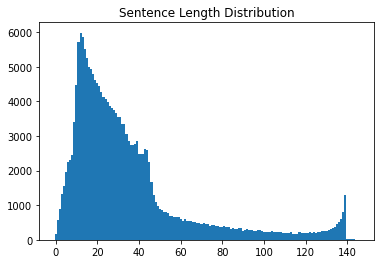

In [4]:
data = list(train_data['document']) + list(test_data['document']) # 훈련 데이터와 학습 데이터를 통합하여 전처리

# 데이터를 얼마나 사용할지 타협점 정의
min_len = 999
max_len = 0
sum_len = 0

for sen in data: 
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [5]:
# 길이가 1인 문장 확인
def check_sentence_with_length(data, length):
    count = 0
    
    for sen in data:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(data, 1)

# 길이가 최장 길이인 문장 확인
check_sentence_with_length(data, 146)

# 확인 필요한 문장 확인
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 4000을 초과하는 문장 길이를 추출
    if _sum > 4000:
        print("Outlier Index:", idx+1)


아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡
"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25


In [6]:
check_sentence_with_length(data, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


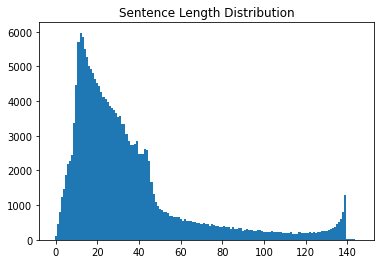

In [7]:
# 문장 중복 제거
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(data))  # set를 사용해서 중복을 제거
                      
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

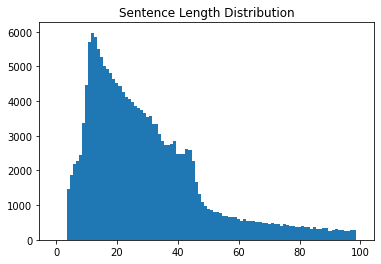

In [8]:
# 길이 너무 긴/짧은 데이터 제거
max_len = 100
min_len = 5

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

#### 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습
* Unigram 타입
* BPE 타입
* CHAR 타입
* WORD 타입

In [9]:
# sentencepiece 모델 학습
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# 디폴트 --model_type = 'unigram'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

# --model_type = 'bpe'
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=naver_review_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

# --model_type = 'char'
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=char --model_prefix=naver_review_spm_char --vocab_size={}'.format(temp_file, vocab_size)    
)

# --model_type = 'word'
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=word --model_prefix=naver_review_spm_word --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l naver_review_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_review_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_review_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab

-rw-r--r-- 1 root root 370635 Aug 16 08:16 naver_review_spm_bpe.model
-rw-r--r-- 1 root root 115831 Aug 16 08:16 naver_review_spm_bpe.vocab
-rw-r--r-- 1 root root 258220 Aug 16 08:16 naver_review_spm_char.model
-rw-r--r-- 1 root root  22081 Aug 16 08:16 naver_review_spm_char.vocab
-rw-r--r-- 1 root root 375167 Aug 16 08:16 naver_review_spm.model
-rw-r--r-- 1 root root 144552 Aug 16 08:16 naver_review_spm.vocab
-rw-r--r-- 1 root root 406005 Aug 16 08:16 naver_review_spm_word.model
-rw-r--r-- 1 root root 175822 Aug 16 08:16 naver_review_spm_word.vocab


In [10]:
# unigram
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_uni = spm.SentencePieceProcessor() 
s_uni.Load('naver_review_spm.model') # unigram 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[1501, 10, 426, 15, 1337, 10, 137, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [11]:
# bpe
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_bpe = spm.SentencePieceProcessor() 
s_bpe.Load('naver_review_spm_bpe.model') # bpe 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[5055, 912, 6554, 6289, 1469, 6285, 6391, 6279, 6277]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [12]:
# char
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_char = spm.SentencePieceProcessor() 
s_char.Load('naver_review_spm_char.model') # char 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_char.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_char.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_char.DecodeIds(tokensIDs))

[3, 15, 190, 11, 12, 281, 16, 36, 22, 12, 118, 6, 4]
[]
아버지가방에들어가신다.


In [13]:
# word
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_word = spm.SentencePieceProcessor() 
s_word.Load('naver_review_spm_word.model') # word 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_word.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_word.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_word.DecodeIds(tokensIDs))

[0]
[]
 ⁇ 


#### 학습된 모델로 sp_tokenize() 메소드 구현
* Unigram 타입
* BPE 타입
* CHAR 타입
* WORD 타입

In [14]:
#unigram
def sp_tokenize_uni(s_uni, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))

    with open("./naver_review_spm.vocab", 'r') as f: # unigram 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)
    # tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 100) 

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, my_corpus)
print(tensor_uni)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  560 3373   14 1377
  2222    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1577 2275  252  588

In [15]:
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, data)
print(tensor_uni.shape)

(195339, 100)


In [16]:
#BPE
def sp_tokenize_bpe(s_bpe, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_bpe.EncodeAsIds(sen))

    with open("./naver_review_spm_bpe.vocab", 'r') as f: # bpe 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)
    # tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 100) 

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, my_corpus)
print(tensor_bpe)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  719 3151 6306  565
   829 6277]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 1680 2303  323

In [17]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, data)
print(tensor_bpe.shape)

(195339, 100)


In [18]:
# char
def sp_tokenize_char(s_char, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_char.EncodeAsIds(sen))

    with open("./naver_review_spm_char.vocab", 'r') as f: # char 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100) 
    # tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 100) 
    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_char, word_index_char, index_word_char = sp_tokenize_char(s_char, my_corpus)
print(tensor_char)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    3   17    7    3  773   33    3  295   77  137   35
     6    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    3   38  117   17    3   80
    64  125    3   94   94    3  119   12    3   10

In [19]:
tensor_char, word_index_char, index_word_char = sp_tokenize_char(s_char, data)
print(tensor_char.shape)

(195339, 100)


In [20]:
# word
def sp_tokenize_word(s_word, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_char.EncodeAsIds(sen))

    with open("./naver_review_spm_word.vocab", 'r') as f: # word 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100) 
    # tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 100) 
    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_word, word_index_word, index_word_word = sp_tokenize_word(s_word, my_corpus)
print(tensor_word)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    3   17    7    3  773   33    3  295   77  137   35
     6    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    3   38  117   17    3   80
    64  125    3   94   94    3  119   12    3   10

In [21]:
tensor_word, word_index_word, index_word_word = sp_tokenize_word(s_word, data)
print(tensor_word.shape)

(195339, 100)


#### 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습
* 토크나이저로 RNN 모델 학습
* train, val, test 분할

In [22]:
# unigram train, val, test 분할
X_train = tensor_uni[:146182]
X_test = tensor_uni[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 12)                1392      
_________________________________________________________________
dense (Dense)                (None, 8)                 104       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 11ms/step - loss: 0.5561 - accuracy: 0.7472 - val_loss: 0.4009 - val_accuracy: 0.8402
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3544 - accuracy: 0.8517 - val_loss: 0.3498 - val_accuracy: 0.8512
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3192 - accuracy: 0.8664 - val_loss: 0.3492 - val_accuracy: 0.8508
Epoch 4/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3068 - accuracy: 0.8725 - val_loss: 0.3484 - val_accuracy: 0.8507
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2986 - accuracy: 0.8758 - val_loss: 0.3489 - val_accuracy: 0.8512
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2917 - accuracy: 0.8788 - val_loss: 0.3503 - val_accuracy: 0.8510
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2847 - accuracy: 0.8821 - val_loss: 0.3554 - val_accuracy: 0.8495
Epoch

1537/1537 - 4s - loss: 0.5691 - accuracy: 0.8331
[0.5690986514091492, 0.8330655097961426]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


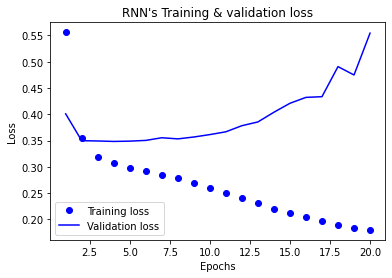

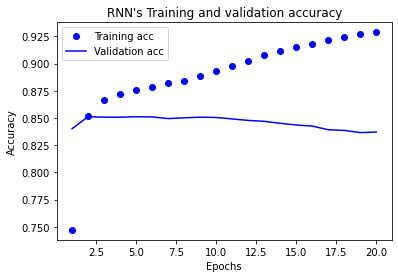

In [25]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
# BPE train, val, test 분할
X_train = tensor_bpe[:146182]
X_test = tensor_bpe[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 4s 11ms/step - loss: 0.5160 - accuracy: 0.7648 - val_loss: 0.3689 - val_accuracy: 0.8403
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3390 - accuracy: 0.8557 - val_loss: 0.3487 - val_accuracy: 0.8505
Epoch 3/20
188/188 [==============================] - 2s 10ms/step - loss: 0.3174 - accuracy: 0.8666 - val_loss: 0.3502 - val_accuracy: 0.8501
Epoch 4/20
188/188 [==============================] - 2s 10ms/step - loss: 0.3072 - accuracy: 0.8720 - val_loss: 0.3512 - val_accuracy: 0.8500
Epoch 5/20
188/188 [==============================] - 2s 10ms/step - loss: 0.3015 - accuracy: 0.8751 - val_loss: 0.3555 - val_accuracy: 0.8470
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2943 - accuracy: 0.8783 - val_loss: 0.3549 - val_accuracy: 0.8481
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2851 - accuracy: 0.8839 - val_loss: 0.3571 - val_accuracy: 0.8497
Ep

1537/1537 - 4s - loss: 0.4920 - accuracy: 0.8297
[0.4920137822628021, 0.8296682238578796]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


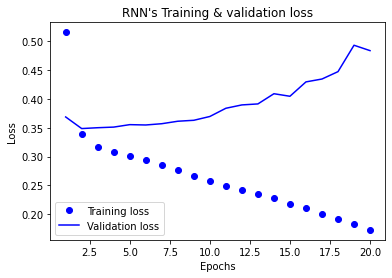

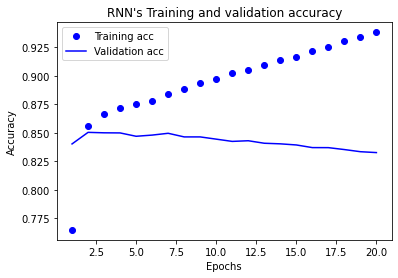

In [29]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
# CHAR train, val, test 분할
X_train = tensor_char[:146182]
X_test = tensor_char[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 11ms/step - loss: 0.5507 - accuracy: 0.7276 - val_loss: 0.4557 - val_accuracy: 0.7897
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4495 - accuracy: 0.7927 - val_loss: 0.4375 - val_accuracy: 0.7989
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4363 - accuracy: 0.8001 - val_loss: 0.4299 - val_accuracy: 0.8031
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4273 - accuracy: 0.8051 - val_loss: 0.4261 - val_accuracy: 0.8043
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4197 - accuracy: 0.8096 - val_loss: 0.4218 - val_accuracy: 0.8057
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4118 - accuracy: 0.8124 - val_loss: 0.4164 - val_accuracy: 0.8080
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4042 - accuracy: 0.8165 - val_loss: 0.4104 - val_accuracy: 0.8108
Epoch

1537/1537 - 4s - loss: 0.3952 - accuracy: 0.8250
[0.3952397108078003, 0.8250300288200378]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


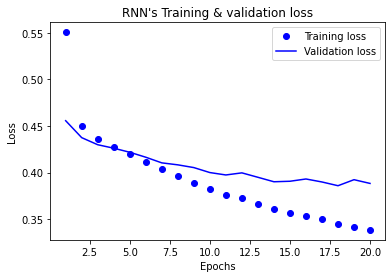

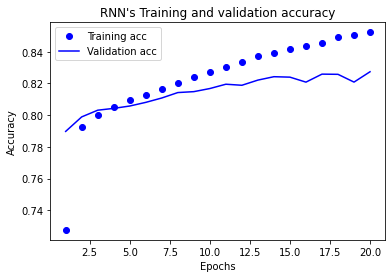

In [33]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
# WORD train, val, test 분할
X_train = tensor_word[:146182]
X_test = tensor_word[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 4s 11ms/step - loss: 0.5775 - accuracy: 0.7026 - val_loss: 0.4794 - val_accuracy: 0.7742
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4554 - accuracy: 0.7918 - val_loss: 0.4425 - val_accuracy: 0.7976
Epoch 3/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4391 - accuracy: 0.8008 - val_loss: 0.4339 - val_accuracy: 0.8015
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4290 - accuracy: 0.8052 - val_loss: 0.4296 - val_accuracy: 0.8031
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4210 - accuracy: 0.8091 - val_loss: 0.4228 - val_accuracy: 0.8061
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4141 - accuracy: 0.8122 - val_loss: 0.4197 - val_accuracy: 0.8075
Epoch 7/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4084 - accuracy: 0.8143 - val_loss: 0.4179 - val_accuracy: 0.8064
Epoch

1537/1537 - 4s - loss: 0.3854 - accuracy: 0.8262
[0.3853563964366913, 0.8261895775794983]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


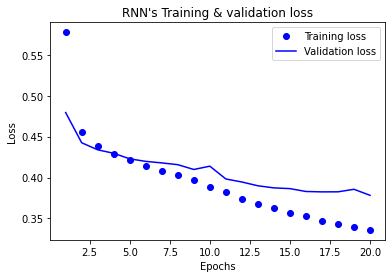

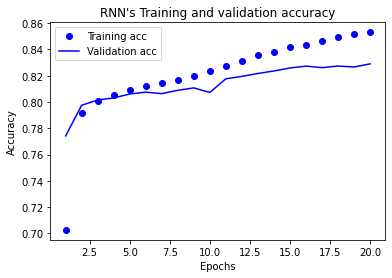

In [37]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### KoNLPy 형태소 분석기를 사용한 모델과 성능 비교
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴
* 상기 사항들로 로더 구성

In [38]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [39]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [40]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [41]:
# 데이터 분석 및 가공
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [42]:
# 데이터셋 내 문장 길이 분포 파악
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [43]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [44]:
# 적절한 최대 문장 길이를 지정
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 설정  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [45]:
# 패딩 작업
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 padding='post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 padding='post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [46]:
# RNN 모델 구성 및 검증 데이터셋 구성
#  validation set 구성
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [47]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 9ms/step - loss: 0.5137 - accuracy: 0.7667 - val_loss: 0.3761 - val_accuracy: 0.8411
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3491 - accuracy: 0.8529 - val_loss: 0.3589 - val_accuracy: 0.8436
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3220 - accuracy: 0.8669 - val_loss: 0.3505 - val_accuracy: 0.8500
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3092 - accuracy: 0.8722 - val_loss: 0.3553 - val_accuracy: 0.8465
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3011 - accuracy: 0.8758 - val_loss: 0.3553 - val_accuracy: 0.8476
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2951 - accuracy: 0.8794 - val_loss: 0.3607 - val_accuracy: 0.8440
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2876 - accuracy: 0.8825 - val_loss: 0.3622 - val_accuracy: 0.8456
Epoch 

1537/1537 - 3s - loss: 0.5213 - accuracy: 0.8312
[0.5212541222572327, 0.8312346339225769]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


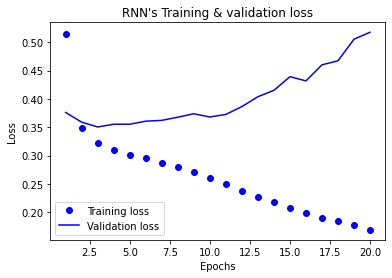

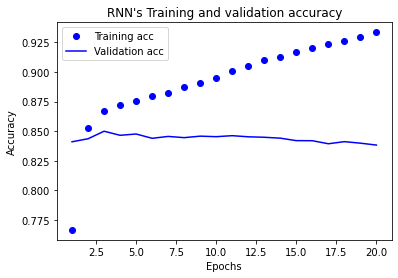

In [49]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인 (정확도)
* padding='pre'
###### Unigram 0.8331 
###### KoNLPy 형태소 분석기 0.8312
###### BPE 0.8297
###### WORD 0.8262
###### CHAR 0.8250
-------------------------------
* padding='post'
###### KoNLPy 형태소 분석기 0.8278
###### WORD 0.8226
###### CHAR 0.7883
###### BPE 0.6061
###### Unigram 0.4972


### 루브릭
#### 평가문항 (상세기준)
* 1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?	
###### 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
* 2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?	
###### SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
* 3. SentencePiece의 성능을 다각도로 비교분석하였는가?	
###### SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

### 회고
* 코드를 계속 복사 붙여넣기로 사용하다보니 너무 길어진 감이 있는데, 좀 더 간추리면 시각적으로나 실제 사용으로나 더 편할 것 같다.
* 전처리를 거의 하지 않았는데 전처리 시 성능이 궁금하다.
* padding을 'post'로 돌렸을 때 sentencepiec 모델의 결과가 확연히 안 좋아지는 것을 확인할 수 있었다. KoNLPY 형태소 분석기의 경우 큰 차이가 없었다.
* 모델 별 성능 차이는 돌릴 때 마다 우위가 달라지는 것으로 보아 편차가 크지 않거나 데이터가 어떻게 주어지는 지에 따른 영향이 더 큰 것으로 보인다.